# Benthic d18O tuning
This notebook shows how we tuned the benthic foraminiferal d18O record to the global benthic oxygen isotope stage (Lisieki & Raymo 2005). The second half of the notebook uses the age-depth modeled d18O record to find the depths of glacial-interglacial transitions at U1474.

## Setup
### Import packages

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.signal as signal
from scipy import interpolate
from scipy import stats
from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import gridspec

### Set paths

In [30]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
misc_path='/Users/danielbabin/GitHub/Green_Bands/Data/Misc/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'

## Tune foraminiferal $\delta^{18}$O
### Import clean benthic foram chemical data from previous notebook

In [31]:
d18o=pd.read_csv(table_path+'Supplementary Table 1 - Benthic foram chemistry.csv')
d18o=d18o.set_index('Top depth CCSF (m)',drop=False)
d18o=d18o.loc[:50].copy()
lr04=pd.read_csv(misc_path+'LR04stack.txt',sep='\t',index_col='Time (ka)')

### Visualize un-tuned record

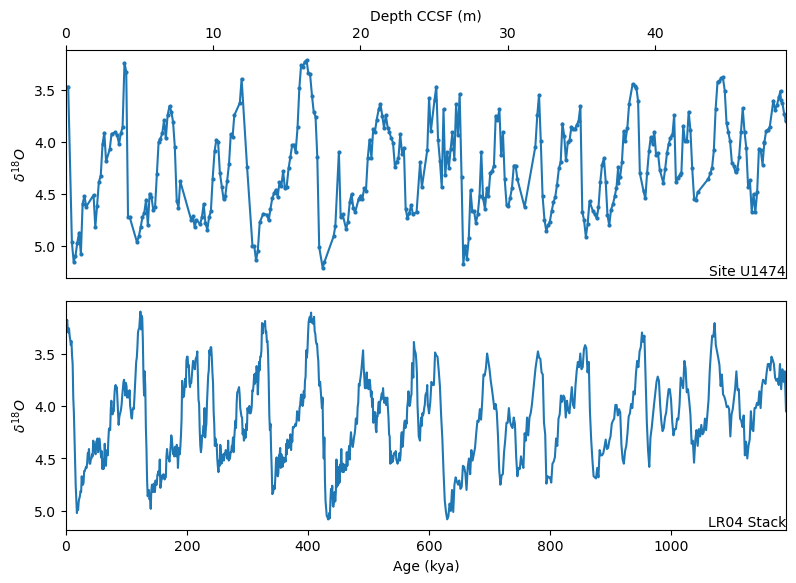

In [33]:
fig,axes=plt.subplots(nrows=2,figsize=(9,6))

for ax in axes:
    ax.invert_yaxis()
    ax.set_ylabel('$\delta^{18}O$')
    
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')

ax=axes[0]
df=d18o['benthic d18O'].dropna().loc[:50]
ax.plot(df.index,df.values,marker='o',ms=2)
ax.set_xlim(0,df.index.max())
ax.set_xlabel('Depth CCSF (m)')

ax=axes[1]
df=lr04['Benthic d18O (per mil)'].dropna().loc[:1190]
ax.plot(df.index,df.values)
ax.set_xlim(0,df.index.max())
ax.set_xlabel('Age (kya)')

ids=['Site U1474','LR04 Stack']
for i,place in enumerate(ids):
    axes[i].annotate(place,xy=(1,0),xycoords='axes fraction',ha='right',va='bottom')

    
plt.subplots_adjust(hspace=.1,left=.1,right=.9,top=.9,bottom=.1)

## Export for QAnalyseries

### Set path extensions

In [35]:
qanalyseries_input='QAnalyseries/Inputs/d18O/'
qanalyseries_output='QAnalyseries/Outputs/d18O/'

### Interpolate foraminiferal d18O

In [36]:
fd18o=interpolate.interp1d(d18o['benthic d18O'].dropna().index,d18o['benthic d18O'].dropna())
xnew=np.linspace(d18o.index.min(),d18o.index.max(),1200)
rs_d18o=pd.DataFrame(index=xnew)
rs_d18o['benthic d18O']=fd18o(xnew)

### Export

In [37]:
rs_d18o['benthic d18O'].dropna().to_csv(data_path+qanalyseries_input+'u1474.csv',header=False)
lr04['Benthic d18O (per mil)'].dropna().loc[:1190].to_csv(data_path+qanalyseries_input+'lr04.csv',header=False)

## Import tiepoints from QAnalyseries

In [38]:
ties=pd.read_csv(data_path+qanalyseries_output+'u1474-on-lr04.txt',sep='\s',header=None,engine='python',
                 names=['Depth CCSF (m)','Age (kyr)'])

## Tune depth record to LR04

### Tiepoints with U1474 on depth

In [39]:
ties=pd.DataFrame(columns=['Depth CCSF (m)','Age (kyr)'])
# chill tune
d=[0,2.3,2.85,4.27,6.15,7.36,9.9,12.3,13.7,15.4,
   17,20.3,22,24.5,26.8,29,29.7,31.7,32.3,33.3,36.6,37.8,40.8,43.9,44.8,d18o.index.max()]
a=[0,73,89,134,191,219,280,336,363,392,
   423,476,505,569,621,685,714,769,791,812.8,916.5,935,992,1061,1084,1175]
ties['Depth CCSF (m)']=d
ties['Age (kyr)']=a

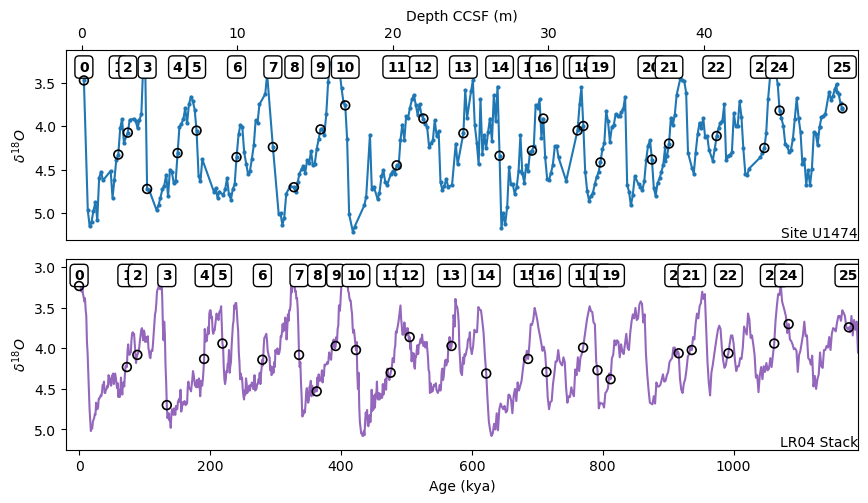

In [40]:
# fig,axes=plt.subplots(nrows=2,figsize=(8,5))
fig,axes=plt.subplots(nrows=2,figsize=(9,5))

for ax in axes:
    ax.invert_yaxis()
    ax.set_ylabel('$\delta^{18}O$')
    
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')

ax=axes[0]
df=d18o['benthic d18O'].dropna().loc[:50]
ax.plot(df.index,df.values,marker='o',ms=2)
ax.set_xlim(-1,df.index.max()+1)
ax.set_xlabel('Depth CCSF (m)')

ax=axes[1]
df=lr04['Benthic d18O (per mil)'].dropna().loc[:1190]
ax.plot(df.index,df.values,color='tab:purple')
ax.set_xlim(-20,df.index.max())
ax.set_xlabel('Age (kya)')
ax.set_ylim(5.25,2.9)

ids=['Site U1474','LR04 Stack']
for i,place in enumerate(ids):
    axes[i].annotate(place,xy=(1,0),xycoords='axes fraction',ha='right',va='bottom')

yname=['benthic d18O','Benthic d18O (per mil)']
for i,df in enumerate([d18o,lr04]):
    xs = ties.iloc[:,i]
    real_xs=[]
    ys=[]
    for x in xs:
        idx=df.index.get_indexer([x],method='nearest')[0]
        real_xs.append(df.iloc[idx].name)
    tps=df.loc[real_xs,yname[i]]
    axes[i].scatter(tps.index,tps.values,facecolor='None',lw=1.2,s=40,marker='o',edgecolor='k',zorder=10);
    
    yu = axes[i].get_ylim()[1]
    for n,x in enumerate(real_xs):
        axes[i].annotate(n,xy=(x,yu+0.2),fontweight='bold',ha="center", va="center",clip_on=True,
                         bbox=dict(boxstyle="round",
                                   ec=(0,0,0),fc=(1,1,1),clip_on=True))
    
plt.subplots_adjust(hspace=.1,left=.07,right=.95,top=.9,bottom=.1)

### Interpolate tiepoints to make age model

In [41]:
am=interp1d(ties['Depth CCSF (m)'],ties['Age (kyr)'],bounds_error=False,fill_value='extrapolate')
d18o['Age (kyr)']=am(d18o.index)
d18o_age=d18o.set_index('Age (kyr)').copy()

### Show U1474 on tuned age model

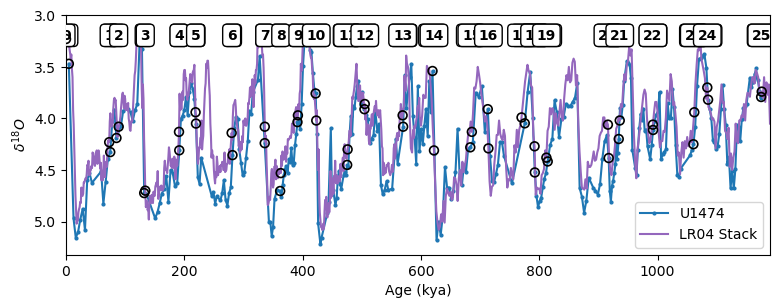

In [42]:
fig,ax=plt.subplots(figsize=(8,3),sharex=True)

ax.invert_yaxis()
ax.set_ylabel('$\delta^{18}O$')

df=d18o_age['benthic d18O'].dropna()
ax.plot(df.index,df.values,marker='o',ms=2,label='U1474')

df=lr04['Benthic d18O (per mil)'].dropna().loc[:1190]
ax.plot(df.index,df.values,label='LR04 Stack',color='tab:purple')
ax.set_xlim(0,df.index.max())
ax.set_xlabel('Age (kya)')

ax.legend()
    
yname=['benthic d18O','Benthic d18O (per mil)']
for i,df in enumerate([d18o_age,lr04]):
    xs = ties.iloc[:,1]
    real_xs=[]
    ys=[]
    for x in xs:
        idx=df.index.get_indexer([x],method='nearest')[0]
        real_xs.append(df.iloc[idx].name)
    tps=df.loc[real_xs,yname[i]]
    ax.scatter(tps.index,tps.values,facecolor='None',s=40,lw=1.2,marker='o',edgecolor='k',zorder=10);
    
    yu = ax.get_ylim()[1]
    for n,x in enumerate(real_xs):
        ax.annotate(n,xy=(x,yu+0.2),fontweight='bold',ha="center", va="center",clip_on=True,
                         bbox=dict(boxstyle="round",
                                   ec='k',fc='w',clip_on=True))
    
plt.subplots_adjust(hspace=.1,left=.07,right=.95,top=.95,bottom=.15)

## Make Figure

In [43]:
d18o=d18o.dropna()
d18o.loc[8,'benthic d18O']=np.nan
d18o=d18o.sort_index()

d18o_age=d18o_age.dropna()
d18o_age.loc[240,'benthic d18O']=np.nan
d18o_age=d18o_age.sort_index()

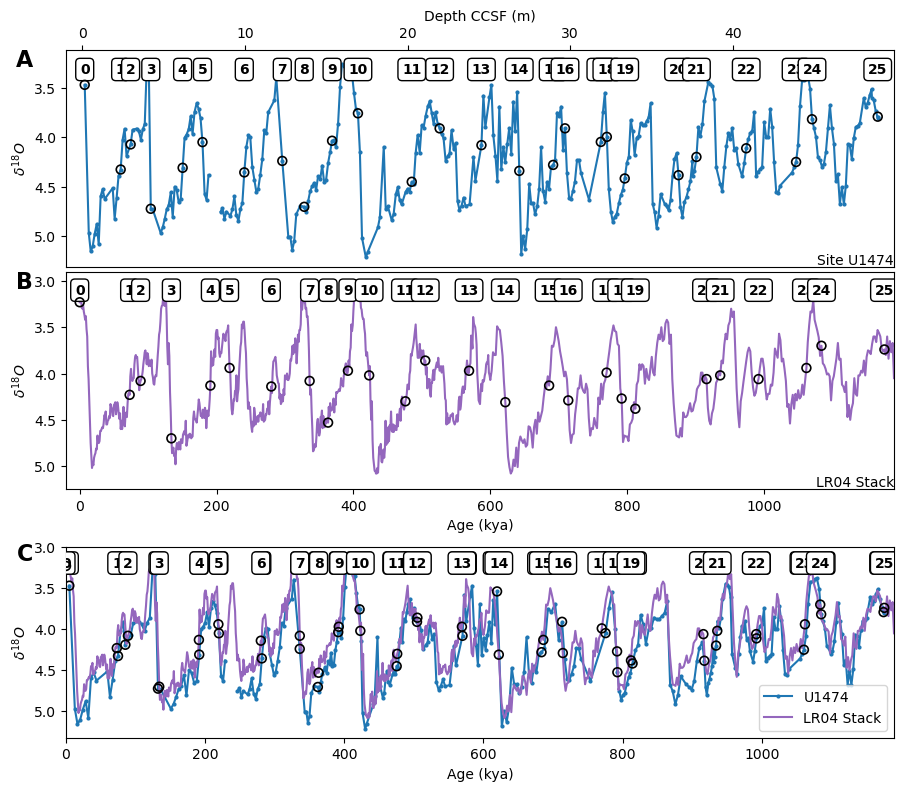

In [44]:
fig = plt.figure(figsize=(9,8),facecolor='white')
gs = gridspec.GridSpec(3, 1, figure=fig,hspace=.3,top=.93,bottom=.07,left=.06,right=.98)
gsA = gs[:2].subgridspec(2, 1,hspace=.02)
gsB = gs[2].subgridspec(1, 1,hspace=0)

ax1 = fig.add_subplot(gsA[0])
ax2 = fig.add_subplot(gsA[1])
ax3 = fig.add_subplot(gsB[0])
axes=[ax1,ax2,ax3]

for ax in axes:
    ax.invert_yaxis()
    ax.set_ylabel('$\delta^{18}O$')
    
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')

ax=axes[0]
df=d18o['benthic d18O'].loc[:50]
ax.plot(df.index,df.values,marker='o',ms=2)
ax.set_xlim(-1,df.index.max()+1)
ax.set_xlabel('Depth CCSF (m)')

ax=axes[1]
df=lr04['Benthic d18O (per mil)'].dropna().loc[:1190]
ax.plot(df.index,df.values,color='tab:purple')
ax.set_xlim(-20,df.index.max())
ax.set_xlabel('Age (kya)')
ax.set_ylim(5.25,2.9)

ids=['Site U1474','LR04 Stack']
for i,place in enumerate(ids):
    axes[i].annotate(place,xy=(1,0),xycoords='axes fraction',ha='right',va='bottom')

yname=['benthic d18O','Benthic d18O (per mil)']
for i,df in enumerate([d18o,lr04]):
    xs = ties.iloc[:,i]
    real_xs=[]
    ys=[]
    for x in xs:
        idx=df.index.get_indexer([x],method='nearest')[0]
        real_xs.append(df.iloc[idx].name)
    tps=df.loc[real_xs,yname[i]]
    axes[i].scatter(tps.index,tps.values,facecolor='None',lw=1.2,s=40,marker='o',edgecolor='k',zorder=10);
    
    yu = axes[i].get_ylim()[1]
    for n,x in enumerate(real_xs):
        axes[i].annotate(n,xy=(x,yu+0.2),fontweight='bold',ha="center", va="center",clip_on=True,
                         bbox=dict(boxstyle="round",
                                   ec=(0,0,0),fc=(1,1,1),clip_on=True))

ax=axes[2]

df=d18o_age['benthic d18O']
ax.plot(df.index,df.values,marker='o',ms=2,label='U1474')

df=lr04['Benthic d18O (per mil)'].dropna().loc[:1190]
ax.plot(df.index,df.values,label='LR04 Stack',color='tab:purple')
ax.set_xlim(0,df.index.max())
ax.set_xlabel('Age (kya)')

ax.legend()
    
yname=['benthic d18O','Benthic d18O (per mil)']
for i,df in enumerate([d18o_age,lr04]):
    xs = ties.iloc[:,1]
    real_xs=[]
    ys=[]
    for x in xs:
        idx=df.index.get_indexer([x],method='nearest')[0]
        real_xs.append(df.iloc[idx].name)
    tps=df.loc[real_xs,yname[i]]
    ax.scatter(tps.index,tps.values,facecolor='None',s=40,lw=1.2,marker='o',edgecolor='k',zorder=10);
    
    yu = ax.get_ylim()[1]
    for n,x in enumerate(real_xs):
        ax.annotate(n,xy=(x,yu+0.2),fontweight='bold',ha="center", va="center",clip_on=True,
                         bbox=dict(boxstyle="round",
                                   ec='k',fc='w',clip_on=True))
letters=['A','B','C']
for i,ax in enumerate(axes):
    ax.annotate(letters[i],xy=(-.04,.9),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                fontsize=16)      

### Calculate sedimentation rates

In [45]:
ties['Sed Rate']=((ties['Depth CCSF (m)']-ties['Depth CCSF (m)'].shift(1))/
                         (ties['Age (kyr)']-ties['Age (kyr)'].shift(1)))*100

### Export tiepoints to checkpoint to make age model in the next notebook

In [48]:
# ties.to_csv(checkpoints_path+'lr04_tie_points.csv',index=False)
export=ties.copy()
export['Sedimentation Rate (cm/ka)']=((export['Depth CCSF (m)'].shift(1)-export['Depth CCSF (m)'])/
                                      (export['Age (kyr)'].shift(1)-export['Age (kyr)']))*100
export=export.rename(columns={'Age (kyr)':'Age (ka BP)'})
export.to_csv(table_path+'Supplementary Table 2 - Age-depth model.csv',index=False)

## Get benthic d18O minima and midpoints for calculate depths of glacial and interglacial transitions

### Glacial marine isotope stage age boundaries from LR04

In [115]:
gs=[[14, 29],[57, 71],[130, 191],[243, 300],[337, 374],[424, 478],[531, 563],[621, 676],
    [712, 761],[790, 814],[866, 900],[917, 936],[959, 970],[982, 1014],[1031, 1062],[1081,1104],
    [1114, 1141],[1190,1215],[1240,1265],[1285,1300]]

In [116]:
gns=np.arange(2,36,2)

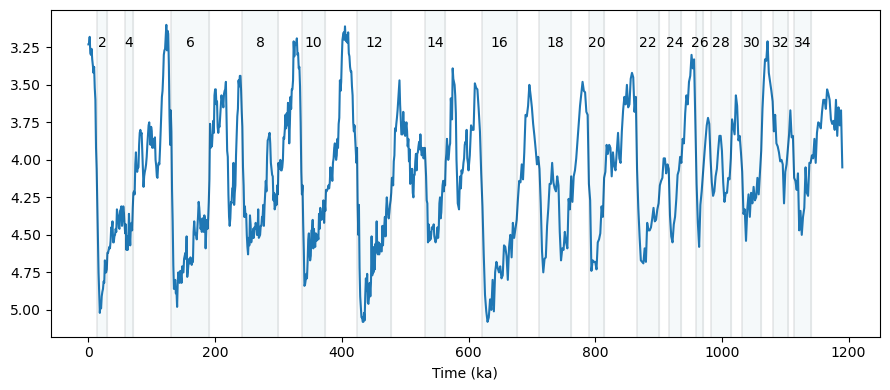

In [117]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(9,4))
lr04['Benthic d18O (per mil)'].dropna().loc[:1190].plot(ax=ax)
ax.invert_yaxis()
glacial_color='#f5f9fa'
for i,g in enumerate(gs[:17]):
    ax.axvspan(xmin=g[0],xmax=g[1],color=glacial_color,zorder=-2)
    ax.axvline(g[0],color='k',lw=.1,zorder=2)
    ax.axvline(g[1],color='k',lw=.1)
    ax.annotate(gns[i],xy=((g[0]+g[1])/2,3.25),ha='center')
plt.tight_layout()

### Enter depths for mins and maxes
These data were extracted using interactive plotting software

In [133]:
mins={'MIS-2':.52,'MIS-4':1.98,'MIS-6':4.206,'MIS-8':8.48,'MIS-10':12.68,
      'MIS-12':17.41,'MIS-14':23.17,'MIS-16':26.97,'MIS-18':29.91,'MIS-20':32.61,
      'MIS-22':35.3,'MIS-24':36.89,'MIS-26':39.22,'MIS-28':40.55,'MIS-30':42.65,
      'MIS-32':45.47,'MIS-34':46.57}
deglaciation_end={'MIS-2':.14,'MIS-4':1.865,'MIS-6':4.10,'MIS-8':8.13,'MIS-10':12.29,
                  'MIS-12':17.05,'MIS-14':22.94,'MIS-16':26.73,'MIS-18':29.67,'MIS-20':32.11,
                  'MIS-22':34.94,'MIS-24':36.65,'MIS-26':38.82,'MIS-28':40.2,'MIS-30':42.41,
                  'MIS-32':44.74,'MIS-34':46.08}
maxes={'MIS-2':1.25,'MIS-4':2.6,'MIS-6':7,'MIS-8':11.92,'MIS-10':16.33,
       'MIS-12':21.36,'MIS-14':24.66,'MIS-16':29.18,'MIS-18':32.11,'MIS-20':34.93,
       'MIS-22':36.54,'MIS-24':38.47,'MIS-26':39.94,'MIS-28':42.27,
       'MIS-30':44.6,'MIS-32':45.96,'MIS-34':48.52}

In [134]:
glacial_depths=pd.DataFrame([mins,deglaciation_end,maxes],index=['Depth Minimum','Depth Deglaciation End',
                                                                 'Depth Previous Interglacial Max']).T

### Get actual depths of sample and calculate d18O values for mins, maxes, and midpoints

In [154]:
glacial_depths['True Min Depth']=d18o.reindex(glacial_depths['Depth Minimum'],
                                              method='nearest')['Top depth CCSF (m)'].values
glacial_depths['True Max Depth']=d18o.reindex(glacial_depths['Depth Previous Interglacial Max'],
                                              method='nearest')['Top depth CCSF (m)'].values
glacial_depths['True Deglaciation End Depth']=d18o.reindex(glacial_depths['Depth Deglaciation End'],
                                              method='nearest').index
glacial_depths['Min d18O']=d18o.loc[glacial_depths['True Min Depth'],'benthic d18O'].values
glacial_depths['Max d18O']=d18o.loc[glacial_depths['True Max Depth'],'benthic d18O'].values
glacial_depths['Midpoint d18O']=(glacial_depths['Min d18O']+glacial_depths['Max d18O'])/2

### Get depths for midpoints from d18O value for midpoints

In [155]:
glacial_depths['Midpoint Depth']=np.nan
for mis in glacial_depths.index:
    df=d18o.loc[glacial_depths.loc[mis,'True Min Depth']:glacial_depths.loc[mis,'True Max Depth']]
    y_midpoint=glacial_depths.loc[mis,'Midpoint d18O']
    
    f=interpolate.interp1d(df['benthic d18O'].dropna().index,df['benthic d18O'].dropna(),bounds_error=False)
    xnew=np.arange(df.index[0],df.index[-1],.01)
    ynew=f(xnew)
    dfnew=pd.Series(ynew,index=xnew)
    
    diff=(dfnew-y_midpoint)
    first_cross=diff.abs().sort_values().iloc[:3].sort_index().index[-1]
    glacial_depths.loc[mis,'Midpoint Depth']=first_cross

### Plot results

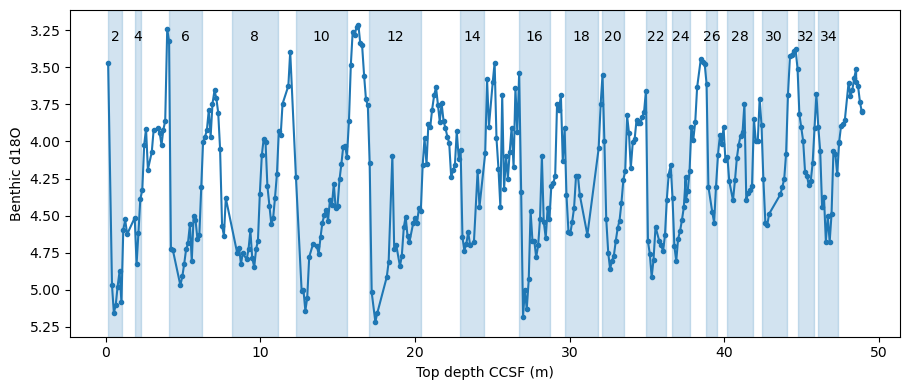

In [156]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(9,4))
d18o['benthic d18O'].dropna().plot(ax=ax,marker='o',ms=3)
ax.invert_yaxis()
plt.tight_layout()
for mis in glacial_depths.index:
    ax.axvspan(xmin=glacial_depths.loc[mis,'Depth Deglaciation End'],
               xmax=glacial_depths.loc[mis,'Midpoint Depth'],color='tab:blue',alpha=.2)
    xmean=(glacial_depths.loc[mis,'Depth Deglaciation End']+glacial_depths.loc[mis,'Midpoint Depth'])/2
    ax.annotate(mis[4:],xy=(xmean,3.25),va='top',ha='center')
ax.set_ylabel('Benthic d18O');

In [157]:
gs_arr=np.array(gs)
glacial_depths['Age Min']=gs_arr[:,0][:-3]
glacial_depths['Age Max']=gs_arr[:,1][:-3]

### Calculate durations

In [158]:
glacial_depths['Glaciation Duration']=glacial_depths['Age Max']-glacial_depths['Age Min']
glacial_depths['Previous Inter-Glacial Duration']=(glacial_depths['Age Min']-
                                                   glacial_depths['Age Max'].shift(1))
glacial_depths.loc['MIS-2','Previous Inter-Glacial Duration']=14

### Calculate thickness per marine isotope stage

In [159]:
glacial_depths['Glacial Thickness']=glacial_depths['Midpoint Depth']-glacial_depths['True Min Depth']
glacial_depths['Inter-Glacial Thickness']=(glacial_depths['Depth Deglaciation End']-
                                           glacial_depths['Midpoint Depth'].shift(1))
glacial_depths.loc['MIS-2','Inter-Glacial Thickness']=glacial_depths.loc['MIS-2','Depth Deglaciation End']

In [160]:
glacial_depths['Glacial Sed Rate']=glacial_depths['Glacial Thickness']/glacial_depths['Glaciation Duration']*100
glacial_depths['Inter-Glacial Sed Rate']=(glacial_depths['Inter-Glacial Thickness']/
                                          glacial_depths['Previous Inter-Glacial Duration']*100)

In [161]:
ig_age_mins=glacial_depths['Age Max'].shift(1)
ig_age_mins.loc['MIS-2']=0

### Make final table

In [163]:
mis_depths=pd.DataFrame(index=range(1,35))
### glacials
mis_depths.loc[mis_depths.index%2==0,'Top Depth (m)']=glacial_depths['True Deglaciation End Depth'].values
mis_depths.loc[mis_depths.index%2==0,'Bottom Depth (m)']=glacial_depths['Midpoint Depth'].values
mis_depths.loc[mis_depths.index%2==0,'Top Age (kyr)']=glacial_depths['Age Min'].values
mis_depths.loc[mis_depths.index%2==0,'Bottom Age (kyr)']=glacial_depths['Age Max'].values

### interglacials
mis_depths.loc[(mis_depths.index%2==1)&
               (mis_depths.index!=1),'Top Depth (m)']=glacial_depths['Midpoint Depth'].values[:-1]
mis_depths.loc[1,'Top Depth (m)']=0
mis_depths.loc[(mis_depths.index%2==1),'Bottom Depth (m)']=glacial_depths['True Deglaciation End Depth'].values
mis_depths.loc[mis_depths.index%2==1,'Top Age (kyr)']=glacial_depths['Age Max'].shift(1).values
mis_depths.loc[1,'Top Age (kyr)']=0
mis_depths.loc[mis_depths.index%2==1,'Bottom Age (kyr)']=glacial_depths['Age Min'].values

mis_depths['Duration (kyr)']=mis_depths['Bottom Age (kyr)']-mis_depths['Top Age (kyr)']
mis_depths['Thickness (cm)']=(mis_depths['Bottom Depth (m)']-mis_depths['Top Depth (m)'])*100
mis_depths['Sedimentation Rate (cm/kyr)']=mis_depths['Thickness (cm)']/mis_depths['Duration (kyr)']

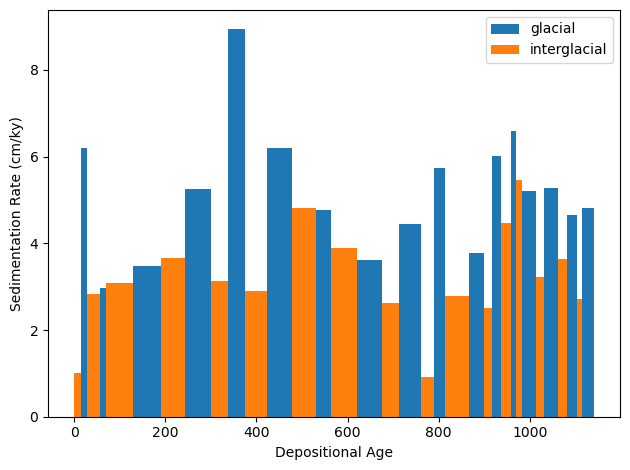

In [164]:
fig,ax=plt.subplots()
gsed=mis_depths[mis_depths.index%2==0]
igsed=mis_depths[mis_depths.index%2==1]

ax.bar(gsed['Top Age (kyr)'],gsed['Sedimentation Rate (cm/kyr)'],gsed['Duration (kyr)'],
       align='edge',label='glacial')
ax.bar(igsed['Top Age (kyr)'],igsed['Sedimentation Rate (cm/kyr)'],igsed['Duration (kyr)'],
       align='edge',label='interglacial')
ax.legend()
ax.set_xlabel('Depositional Age')
ax.set_ylabel('Sedimentation Rate (cm/ky)')
plt.tight_layout()

In [165]:
mis_depths=mis_depths.reset_index()
mis_depths=mis_depths.rename(columns={'index':'MIS'})

### Minor Fine Tuning Glacial->Interglacial Transitions
Fix 8->7 boundary, there's a gap in data and a green layer ends up in the interglacial because of my algorithm
Adjust 9->8 boundary 9 cm.

In [166]:
mis_depths.loc[6,'Bottom Depth (m)']=8.3
mis_depths.loc[7,'Top Depth (m)']=8.3

mis_depths.loc[8,'Bottom Depth (m)']=12.2
mis_depths.loc[9,'Top Depth (m)']=12.2

## Export to checkpoints
This data will be used for grouping green bands by the marine isotope stage they occur in.

In [167]:
mis_depths.to_csv(checkpoints_path+'U1474 Marine Isotope Stage Depths.csv',index=False)